In [1]:
"""
Summaries of USFS TreeMap linked to FIA plot data
Emphasis on 
    - Metrics of forest composition
    - Ecological gradients of species dominance
    - Forest structure (abundance, dominance, diversity, stand height)

Aggregate these statistics to FRP gridcells.

Author: maxwell.cook@colorado.edu
"""

import os, sys

# Custom functions
sys.path.append(os.path.join(os.getcwd(),'code/'))
from __functions import *

albers = 'EPSG:5070' # albers CONUS
utm = 'EPSG:32613' # UTM Zone 13N

maindir = '/Users/max/Library/CloudStorage/OneDrive-Personal/mcook/'
projdir = os.path.join(maindir, 'aspen-fire/Aim2/')

print("Ready to go !")

Ready to go !


In [2]:
# load the aggregated FRP grids (regular 375m2 grids summarizing FRP from VIIRS)
fp = os.path.join(projdir,'data/spatial/mod/VIIRS/viirs_snpp_jpss1_afd_latlon_fires_pixar_gridstats.gpkg')
grid = gpd.read_file(fp)
print(f"\nThere are [{len(grid)}] grids across [{len(grid['Fire_ID'].unique())}] fires.\n")

# add the centroid lat/lon to the grid data
df = grid.to_crs(4326) # WGS coords for lat/lon
df['x'] = df.geometry.centroid.x  # Longitude (x-coordinate)
df['y'] = df.geometry.centroid.y
grid = grid.merge(df[['grid_index','x','y']], on='grid_index', how='left')
del df
print(f"\n{grid.columns}\n")

# Drop any dupicate grids ...
print(f"Dropping [{grid.duplicated(subset=['grid_index','Fire_ID']).sum()}] duplicate grids.\n")
grid = grid.drop_duplicates(subset=['grid_index','Fire_ID'], keep='first')


There are [57232] grids across [100] fires.


Index(['grid_index', 'grid_area', 'afd_count', 'unique_days', 'overlap',
       'frp_csum', 'frp_max', 'frp_min', 'frp_mean', 'frp_p90', 'frp_p95',
       'frp_p97', 'frp_p99', 'frp_first', 'day_max_frp', 'dt_max_frp',
       'first_obs_date', 'last_obs_date', 't4_max', 't4_mean', 't5_max',
       't5_mean', 'day_count', 'night_count', 'frp_max_day', 'frp_max_night',
       'frp_csum_day', 'frp_csum_night', 'frp_mean_day', 'frp_mean_night',
       'frp_p90_day', 'frp_p90_night', 'frp_p95_day', 'frp_p95_night',
       'frp_p97_day', 'frp_p97_night', 'frp_p99_day', 'frp_p99_night',
       'frp_first_day', 'frp_first_night', 'Fire_ID', 'Fire_Name', 'geometry',
       'x', 'y'],
      dtype='object')

Dropping [930] duplicate grids.



Fractional overlap:
count    57232.000000
mean         2.023404
std          2.001402
min          0.000003
25%          0.587511
50%          1.493563
75%          2.771206
max         24.470760
Name: overlap, dtype: float64



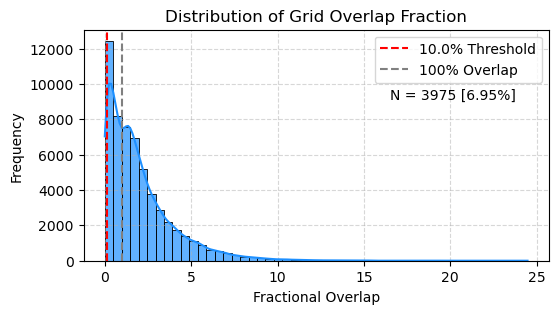

Plot saved to: /Users/max/Library/CloudStorage/OneDrive-Personal/mcook/aspen-fire/Aim2/figures/grid_overlap_distribution.png


In [3]:
# Check out the distribution of grid overlap with FRP observations
thresh = 0.10
print(f"Fractional overlap:\n{grid['overlap'].describe()}\n")
n_small = grid[grid['overlap'] < thresh]['grid_index'].count() # less than 5% spatial overlap

# Plot the distribution of the fractional overlap
plt.figure(figsize=(6,3))
sns.histplot(grid['overlap'], kde=True, bins=50, color='dodgerblue', alpha=0.7)

# Add vertical line for the threshold and for 100%
plt.axvline(x=thresh, color='red', linestyle='--', label=f'{thresh*100}% Threshold')
plt.axvline(x=1, color='grey', linestyle='--', label='100% Overlap')

# Customize the plot
plt.title('Distribution of Grid Overlap Fraction')
plt.xlabel('Fractional Overlap')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.text(16.5, plt.ylim()[1] * 0.7, 
         f'N = {n_small} [{round(n_small/len(grid)*100,2)}%]', 
         fontsize=10, color='black')

# Save the plot
out_path = os.path.join(projdir, 'figures/grid_overlap_distribution.png')
plt.savefig(out_path, dpi=300, bbox_inches='tight')

plt.show()
print(f"Plot saved to: {out_path}")

In [4]:
# filter out grids below the overlap threshold
print(f"Dropping [{n_small} ({round(n_small/len(grid)*100,2)}%)] grids with <{thresh*100}% fractional overlap.")
grid = grid[grid['overlap'] >= thresh] # remove these observations
print(len(grid))

Dropping [3975 (6.95%)] grids with <10.0% fractional overlap.
53257


In [5]:
# Load the TreeMap (ca. 2016)
# Pixel values here denote the FIA plot ID ("tm_id")
# see '04a_TreeMap_FIA-Prep.ipynb'
# fp = os.path.join(maindir,'data/landcover/USFS/RDS_TreeMap/TreeMap2016.tif') # tm_id band
fp = os.path.join(projdir, "data/spatial/mod/USFS/TreeMap_2016_TMID_FORTYPCD.tif") # multi-band
treemap_da = rxr.open_rasterio(fp, masked=True, cache=False).squeeze()
tmid_da = treemap_da.sel(band=1) # the "tm_id" band

# Grab some raster metadata from one of the layers
shp, gt, wkt, nd = tmid_da.shape, tmid_da.spatial_ref.GeoTransform, tmid_da.rio.crs, tmid_da.rio.nodata
print(
    f"Shape: {shp}; \n"
    f"GeoTransform: {gt}; \n"
    f"WKT: {wkt}; \n"
    f"NoData Value: {nd}; \n"
    f"Data Type: {tmid_da[0].dtype}")

del treemap_da
gc.collect()

Shape: (28724, 17006); 
GeoTransform: -1193295.0 30.0 0.0 2253345.0 0.0 -30.0; 
WKT: EPSG:5070; 
NoData Value: nan; 
Data Type: float32


131

In [6]:
# create a forest/non-forest grid
forest_mask = xr.where(~np.isnan(tmid_da), 1, 0)
# calculate the total forested pixels
# see __functions.py 'compute_band_stats'
forest_pct = compute_band_stats(grid, forest_mask, 'grid_index', attr='constant')
forest_pct.rename(columns={
    'pct_cover': 'forest_pct',
    'total_pixels': 'forest_pixels'
}, inplace=True)
forest_pct = forest_pct[forest_pct['constant'] == 1] # just forest pixels
forest_pct = forest_pct[['grid_index','forest_pixels','forest_pct']]

# how many forested grids are there? (>50%)
n_forest = len(forest_pct[forest_pct['forest_pct'] > 50])
print(f"\n[{round(n_forest/len(grid)*100,2)}%] predominantly forest grids.")
print(f"\n{forest_pct.head(3)}")

# Save as a GeoTIFF
out_fp = os.path.join(projdir, "data/spatial/mod/USFS/TreeMap_2016_forestmask.tif")
forest_mask.rio.to_raster(out_fp, compress='zstd', zstd_level=9, dtype='uint16', driver='GTiff')
print(f"\nSaved multi-band raster to: {out_fp}")

# Join to the grid data
grid = grid.merge(forest_pct, on='grid_index', how='left')
print(f"\n{grid.columns}")

print("\n~~~~~~~~~~~~~~~\n")
del forest_mask, forest_pct
gc.collect() # clean up


[85.75%] predominantly forest grids.

   grid_index  forest_pixels  forest_pct
0     1955421            169  100.000000
2     1955422            182   91.758242
4     1955423            169   73.372781

Saved multi-band raster to: /Users/max/Library/CloudStorage/OneDrive-Personal/mcook/aspen-fire/Aim2/data/spatial/mod/USFS/TreeMap_2016_forestmask.tif

Index(['grid_index', 'grid_area', 'afd_count', 'unique_days', 'overlap',
       'frp_csum', 'frp_max', 'frp_min', 'frp_mean', 'frp_p90', 'frp_p95',
       'frp_p97', 'frp_p99', 'frp_first', 'day_max_frp', 'dt_max_frp',
       'first_obs_date', 'last_obs_date', 't4_max', 't4_mean', 't5_max',
       't5_mean', 'day_count', 'night_count', 'frp_max_day', 'frp_max_night',
       'frp_csum_day', 'frp_csum_night', 'frp_mean_day', 'frp_mean_night',
       'frp_p90_day', 'frp_p90_night', 'frp_p95_day', 'frp_p95_night',
       'frp_p97_day', 'frp_p97_night', 'frp_p99_day', 'frp_p99_night',
       'frp_first_day', 'frp_first_night', 'Fire_ID', 'Fir

16

## TreeMap Tree Table

Summary of the the TreeMap Tree Table information within forested grids identified above. Specifically, we can retrieve an estimate of aspen abundance that goes beyond the algorithmic forest type code assigned to a pixel. In this, we can infer understory/overstory compositions potential to that area.

In [7]:
# get the count/proportion of unique "tm_id" from TreeMap in grids
t0 = time.time()

# see __functions.py
grid_trees = compute_band_stats(grid, tmid_da, 'grid_index', attr='tm_id')

# tidy columns in the summary table
grid_trees['count'] = grid_trees['count'].astype(int)
grid_trees['total_pixels'] = grid_trees['total_pixels'].astype(int)
grid_trees.rename(columns={
    'count': 'tmid_count',
    'pct_cover': 'tmid_pct'
}, inplace=True)

# load the TreeMap Tree Table
fp = os.path.join(maindir,'data/landcover/USFS/RDS_TreeMap/TreeMap2016_tree_table.csv')
tree_tbl = pd.read_csv(fp)
print(tree_tbl.columns)

# join the Tree Table to the grid data
grid_trees = grid_trees.merge(tree_tbl, on='tm_id', how='left')
print(f"\n{grid_trees.head(12)}")

t1 = (time.time() - t0) / 60
print(f"\nTotal elapsed time: {t1:.2f} minutes.")
print("\n~~~~~~~~~~\n")

del tmid_da, tree_tbl # clean up 
gc.collect()

Index(['tm_id', 'CN', 'STATUSCD', 'TPA_UNADJ', 'SPCD', 'COMMON_NAME',
       'SCIENTIFIC_NAME', 'SPECIES_SYMBOL', 'DIA', 'HT', 'ACTUALHT', 'CR',
       'SUBP', 'TREE', 'AGENTCD'],
      dtype='object')

    grid_index  tm_id  tmid_count  total_pixels  tmid_pct            CN  \
0      1955421   5490           3           169  1.775148  3.123179e+13   
1      1955421   5490           3           169  1.775148  3.123179e+13   
2      1955421   5490           3           169  1.775148  3.123179e+13   
3      1955421   5490           3           169  1.775148  3.123179e+13   
4      1955421   5490           3           169  1.775148  3.123179e+13   
5      1955421   5490           3           169  1.775148  3.123179e+13   
6      1955421   5490           3           169  1.775148  3.123179e+13   
7      1955421   5490           3           169  1.775148  3.123179e+13   
8      1955421   5490           3           169  1.775148  3.123179e+13   
9      1955421  12327           1           169

44

In [8]:
# Calculate the Tree Table statistics across tm_id/grid_index combinations
#### Abundance (trees/acre, scaled to per-pixel)
#### Dominance (live basal area, scaled to per-pixel)
#### Tree height (average/species)

# force species name to lower case
grid_trees.rename(columns={'COMMON_NAME': 'species'}, inplace=True)
grid_trees['species'] = grid_trees['species'].str.lower()
# tidy the live/dead column
grid_trees['live_dead'] = (grid_trees['STATUSCD'] == 1).astype(int)
# add a tree/pixel based on scaling factor
grid_trees['tpp_unadj'] = grid_trees['TPA_UNADJ'] * 0.222395
# calculate live basal area (balive) scaled by TPA
grid_trees['BA'] = np.pi * (grid_trees['DIA'] / 2) ** 2  # Basal area in square feet
grid_trees['BA_TPAsc'] = grid_trees['BA'] * grid_trees['tpp_unadj']  # adjust based on tree abundance

# group by grid_index and plot identifier (tm_id)
# calculate statistics for live/dead seperately
# merge into a single dataframe

# live trees
live_metrics = (
    grid_trees[grid_trees['live_dead'] == 1]
    .groupby(['grid_index', 'tm_id', 'species'], as_index=False)
    .agg(
        # grid-level attributes
        tmid_pixels=('tmid_count','max'), # retains the tm_id pixel count
        tmid_pct=('tmid_pct','max'), # retain the percent of forested area
        # shannon_h=('shannon_h','max'), # retains the tm_id shannon index
        # calculate species-level attributes
        tpp_live=('tpp_unadj','sum'), # sum of the trees/pixel
        ba_live=('BA_TPAsc', 'sum'),    # total BALIVE
        tree_ht_live=('ACTUALHT','mean') # average tree height
    )
)

# dead trees
dead_metrics = (
    grid_trees[grid_trees['live_dead'] == 0]
    .groupby(['grid_index', 'tm_id', 'species'], as_index=False)
    .agg(
        tpp_dead=('tpp_unadj','sum'), # sum of the trees/pixel
        ba_dead=('BA_TPAsc', 'sum'),    # Live basal area
        tree_ht_dead=('ACTUALHT','mean') # average tree height
    )
)

# combine live/dead balive
tree_metrics = live_metrics.merge(
    dead_metrics, 
    on=['grid_index', 'tm_id', 'species'], 
    how='outer'
).fillna(0)

# subset to the tree metric columns
tree_metrics = tree_metrics[['grid_index','tm_id','tmid_pixels','tmid_pct','species',
                             'ba_live','ba_dead', # basal area
                             'tpp_live','tpp_dead', # trees/pixel
                             'tree_ht_live','tree_ht_dead']] # tree height

# Add Quadratic Mean Diameter (QMD) for live and dead trees
tree_metrics['qmd_live'] = np.where(
    tree_metrics['tpp_live'] > 0, 
    np.sqrt(tree_metrics['ba_live'] / (tree_metrics['tpp_live'] * 0.005454)), 
    0
)
tree_metrics['qmd_dead'] = np.where(
    tree_metrics['tpp_dead'] > 0, 
    np.sqrt(tree_metrics['ba_dead'] / (tree_metrics['tpp_dead'] * 0.005454)), 
    0
)

# Add combined (live + dead)
tree_metrics['tpp_ld'] = tree_metrics['tpp_live'] + tree_metrics['tpp_dead']
tree_metrics['ba_ld'] = tree_metrics['ba_live'] + tree_metrics['ba_dead']
tree_metrics['qmd_ld'] = tree_metrics['qmd_live'] + tree_metrics['qmd_dead']

# add in forest percent by grid
tree_metrics = tree_metrics.merge(
    grid[['grid_index','forest_pixels','forest_pct']], 
    on='grid_index', 
    how='left'
)

# filter out any rows with missing information
tree_metrics = tree_metrics[tree_metrics['tmid_pixels'] > 0]
print(f"\n{tree_metrics.head(12)}\n")
del live_metrics, dead_metrics, grid_trees
gc.collect()


    grid_index  tm_id  tmid_pixels  tmid_pct                      species  \
0        34602   3897          8.0  4.419890                   gambel oak   
1        34602   3897          8.0  4.419890               ponderosa pine   
2        34602   3897          8.0  4.419890                quaking aspen   
3        34602   4118          1.0  0.552486  common or two-needle pinyon   
4        34602   4118          1.0  0.552486                   gambel oak   
7        34602   4121          7.0  3.867403              oneseed juniper   
8        34602   4870          5.0  2.762431  common or two-needle pinyon   
9        34602   4870          5.0  2.762431                 utah juniper   
10       34602   4876          4.0  2.209945                 utah juniper   
11       34602   9611          3.0  1.657459                 jeffrey pine   
12       34602   9611          3.0  1.657459            singleleaf pinyon   
13       34602   9937          1.0  0.552486         california black oak  

0

In [9]:
unique_spp = tree_metrics['species'].unique()
unique_spp

array(['gambel oak', 'ponderosa pine', 'quaking aspen',
       'common or two-needle pinyon', 'oneseed juniper', 'utah juniper',
       'jeffrey pine', 'singleleaf pinyon', 'california black oak',
       'canyon live oak', 'douglas-fir', 'incense-cedar', 'white fir',
       'western juniper', 'alligator juniper', 'rocky mountain juniper',
       'sugar pine', 'loblolly pine', 'loblolly-bay', 'longleaf pine',
       'redbay', 'slash pine', 'swamp tupelo', 'sweetbay', 'water oak',
       'arizona white oak', 'emory oak', 'california live oak',
       'lodgepole pine', 'chokecherry', 'western larch',
       'california red fir', 'western white pine', 'engelmann spruce',
       'subalpine fir', 'narrowleaf cottonwood', 'plains cottonwood',
       'pondcypress', 'eastern redcedar', 'green ash',
       'eastern cottonwood', 'bur oak', 'other or unknown live tree',
       'peachleaf willow', 'willow spp.', 'black cottonwood',
       'arizona pinyon pine', 'pacific dogwood',
       'curlleaf m

In [10]:
pj = tree_metrics['species'].str.contains('pinon|pinyon|juniper', regex=True)
tree_metrics[pj]['species'].value_counts()

species
common or two-needle pinyon    143308
rocky mountain juniper         123436
utah juniper                    93889
western juniper                 41916
alligator juniper               39986
oneseed juniper                 35144
singleleaf pinyon               13914
arizona pinyon pine              7018
california juniper               5406
redberry juniper                 4158
ashe juniper                      108
mexican pinyon pine                87
border pinyon                      47
pinchot juniper                     9
Name: count, dtype: int64

In [11]:
# Identify the primary species from the Tree Table
# identify the species which make up 97% of landscape
spp_pr = (
    tree_metrics.groupby('species', as_index=False)
    .agg(
        balive=('ba_live', 'sum'),
        ba_ld=('ba_ld', 'sum'),
        tpa_live=('tpp_live', 'sum'),
        tpa_ld=('tpp_ld', 'sum') # live+dead
    )
)
# calculate the fractions for both BALIVE and TPA
spp_pr['balive_f'] = spp_pr['balive'] / spp_pr['balive'].sum()
spp_pr['ba_ld_f'] = spp_pr['ba_ld'] / spp_pr['ba_ld'].sum() # live+dead
spp_pr['tpa_live_f'] = spp_pr['tpa_live'] / spp_pr['tpa_live'].sum()
spp_pr['tpa_ld_f'] = spp_pr['tpa_ld'] / spp_pr['tpa_ld'].sum() # live+dead
# sort values and gather the primary species
spp_pr = spp_pr.sort_values(by='ba_ld_f', ascending=False)
# which species make up 97% of observations?
spp_pr['balive_f_csum'] = spp_pr['balive_f'].cumsum()
spp_pr['ba_ld_f_csum'] = spp_pr['ba_ld_f'].cumsum() # live+dead
spp_pr['tpa_live_f_csum'] = spp_pr['tpa_live_f'].cumsum()
spp_pr['tpa_ld_f_csum'] = spp_pr['tpa_ld_f'].cumsum() # live+dead

metric = 'ba_ld_f_csum'
top_species = spp_pr[(spp_pr['ba_ld_f_csum'] <= 0.97) | (spp_pr['tpa_ld_f_csum'] <= 0.97)]
print(f"\nSpecies making up 97% of *{metric}*: \n\n{top_species[['species','ba_ld_f','tpa_ld_f']]}\n\n")

del spp_pr
gc.collect()


Species making up 97% of *ba_ld_f_csum*: 

                         species   ba_ld_f  tpa_ld_f
132               ponderosa pine  0.218414  0.122107
99                lodgepole pine  0.184919  0.249160
135                quaking aspen  0.084519  0.095473
64                   douglas-fir  0.079969  0.052120
74              engelmann spruce  0.067212  0.055002
171                subalpine fir  0.059905  0.091382
185                 utah juniper  0.042737  0.017545
200                    white fir  0.039848  0.028985
80                     grand fir  0.028420  0.018055
59   common or two-needle pinyon  0.025757  0.027556
78                    gambel oak  0.024857  0.134907
146       rocky mountain juniper  0.014865  0.011994
92                  jeffrey pine  0.012381  0.004603
116              oneseed juniper  0.011132  0.003671
61                  corkbark fir  0.008874  0.006950
95                   limber pine  0.008428  0.007215
0              alligator juniper  0.007405  0.002848
19

0

In [12]:
# subset to Southern Rockies species
srm_spps = [
    'ponderosa pine', 'lodgepole pine', 'quaking aspen', 'douglas-fir',
    'engelmann spruce', 'subalpine fir', 'utah juniper', 'white fir',
    'common or two-needle pinyon', 'gambel oak',
    'rocky mountain juniper', 'oneseed juniper',
    'limber pine', 'singleleaf pinyon', 
    'blue spruce', 'curlleaf mountain-mahogany'
]

# get the species co-occurrence percentages
coo = get_spp_coo(tree_metrics, srm_spps, grid_col='tm_id', sp_col='species') # see '__functions.py')
print(f"\n{coo.head(30)}\n")


Species occurrence counts:
species
ponderosa pine                 537268
douglas-fir                    355901
lodgepole pine                 322556
quaking aspen                  250964
engelmann spruce               202214
subalpine fir                  185194
gambel oak                     170224
common or two-needle pinyon    143308
white fir                      132091
rocky mountain juniper         123436
utah juniper                    93889
limber pine                     61208
oneseed juniper                 35144
blue spruce                     22922
curlleaf mountain-mahogany      14235
singleleaf pinyon               13914
Name: count, dtype: int64


                                         species_pair  coo_count    coo_pct
21                      (douglas-fir, ponderosa pine)        787  12.848980
35                  (engelmann spruce, subalpine fir)        607   9.910204
72                    (lodgepole pine, subalpine fir)        484   7.902041
0         (common or two

In [13]:
# Subset to Southern Rockies species
tree_metrics = tree_metrics[tree_metrics['species'].isin(srm_spps)]

# Aggregate species into forest groups
# These groups represent common pairings for the Southern Rockies
spp_grouping = {
    'common or two-needle pinyon|singleleaf pinyon|utah juniper|oneseed juniper': 'Piñon-juniper',
    'rocky mountain juniper': 'Rocky mountain juniper',
    'engelmann spruce|subalpine fir': 'Spruce-fir',
    'ponderosa pine': 'Ponderosa', 
    'lodgepole pine': 'Lodgepole',
    'aspen': 'Quaking aspen',
    'douglas-fir|white fir': 'Mixed-conifer',
    'gambel oak': 'Gambel oak',
}

# # Alternate:
# spp_grouping = {
#     'common or two-needle pinyon|singleleaf pinyon|utah juniper|oneseed juniper': 'Piñon-juniper',
#     'rocky mountain juniper': 'Rocky mountain juniper',
#     'engelmann spruce': 'Engelmann spruce',
#     'subalpine fir': 'Subalpine fir',
#     'ponderosa pine': 'Ponderosa pine', 
#     'lodgepole pine': 'Lodgepole pine',
#     'aspen': 'Quaking aspen',
#     'douglas-fir': 'Douglas-fir',
#     'white fir': 'White fir',
#     'gambel oak': 'Gambel oak',
# }

spp_remap = {} # dictionary to store the remap values
# Iterate over groups to create the species remap dictionary
for keywords, spp_group in spp_grouping.items():
    # Find species matching the keywords
    spp = tree_metrics[tree_metrics['species'].str.contains(keywords, case=False, na=False)]
    # Add matching species to the remap dictionary
    spp_remap.update({name: spp_group for name in spp['species'].unique()})

# Apply the remap to create a new grouped species column
tree_metrics['species_gp_n'] = tree_metrics['species'].map(spp_remap).fillna(tree_metrics['species'])
# Verify the updated species groups
print(tree_metrics[['species', 'species_gp_n']].drop_duplicates().head(10))
print(f"\n{tree_metrics.columns}")

                        species            species_gp_n
0                    gambel oak              Gambel oak
1                ponderosa pine               Ponderosa
2                 quaking aspen           Quaking aspen
3   common or two-needle pinyon           Piñon-juniper
7               oneseed juniper           Piñon-juniper
9                  utah juniper           Piñon-juniper
12            singleleaf pinyon           Piñon-juniper
15                  douglas-fir           Mixed-conifer
18                    white fir           Mixed-conifer
34       rocky mountain juniper  Rocky mountain juniper

Index(['grid_index', 'tm_id', 'tmid_pixels', 'tmid_pct', 'species', 'ba_live',
       'ba_dead', 'tpp_live', 'tpp_dead', 'tree_ht_live', 'tree_ht_dead',
       'qmd_live', 'qmd_dead', 'tpp_ld', 'ba_ld', 'qmd_ld', 'forest_pixels',
       'forest_pct', 'species_gp_n'],
      dtype='object')


In [14]:
# re-aggregate the TreeMap characteristics by FRP grid/species combinations
# summarizes forest metrics by individual species present in the grid cell
# now, summarizes against the new forest groups made above
grid_tm = (
    tree_metrics.groupby(
        ['grid_index', 'species_gp_n'], as_index=False
    ).agg(
        tmid_n=('tm_id', 'nunique'), # number of unique tm_id contributing
        forest_pct=('forest_pct','max'), # retains the forest pixel count for the grid
        ba_live=('ba_live', 'sum'),
        ba_dead=('ba_dead', 'sum'), 
        ba_ld=('ba_ld', 'sum'),
        tpp_live=('tpp_live', 'sum'),  
        tpp_dead=('tpp_dead', 'sum'),
        tpp_ld=('tpp_ld', 'sum'),
        qmd_live=('qmd_live', 'mean'),
        qmd_dead=('qmd_dead', 'mean'),
        qmd_ld=('qmd_ld', 'mean'),
        tree_ht_live=('tree_ht_live', 'mean'),
        tree_ht_dead=('tree_ht_dead', 'mean')
    )
)

# Check results
print(f"\n{grid_tm.head(10)}\n")

# clean up !
del tree_metrics
gc.collect()


   grid_index            species_gp_n  tmid_n  forest_pct       ba_live  \
0       34602              Gambel oak       4   99.450549    983.074924   
1       34602           Mixed-conifer       1   99.450549   1757.987391   
2       34602           Piñon-juniper      12   99.450549  25166.851413   
3       34602               Ponderosa       4   99.450549   3753.173956   
4       34602           Quaking aspen       1   99.450549     40.406737   
5       34602  Rocky mountain juniper       1   99.450549    104.916661   
6       34603              Gambel oak       5   98.816568   2033.707019   
7       34603           Mixed-conifer       4   98.816568   3991.778414   
8       34603           Piñon-juniper      12   98.816568  16933.559057   
9       34603               Ponderosa       9   98.816568  11413.025390   

       ba_dead         ba_ld    tpp_live   tpp_dead      tpp_ld    qmd_live  \
0    36.591012   1019.665936  106.112034   1.338383  107.450417   46.751662   
1   131.985888 

54

In [15]:
# Re-assess the primary species after the regrouping
spp_pr = (
    grid_tm.groupby('species_gp_n', as_index=False)
    .agg(
        ba_ld=('ba_ld','sum'),
        tpp_ld=('tpp_ld', 'sum')
    )
)

# calculate the fraction
spp_pr['balive_f'] = spp_pr['ba_ld'] / spp_pr['ba_ld'].sum()
spp_pr['tpa_live_f'] = spp_pr['tpp_ld'] / spp_pr['tpp_ld'].sum()
# sort values and gather the primary species
spp_pr = spp_pr.sort_values(by='balive_f', ascending=False)
# which species make up 97% of observations?
spp_pr['balive_f_csum'] = spp_pr['balive_f'].cumsum()
spp_pr['tpa_live_f_csum'] = spp_pr['tpa_live_f'].cumsum()
top_species = spp_pr[(spp_pr['balive_f_csum'] <= 0.97) | (spp_pr['balive_f'] > 0.01)]
print(
    f"\nSpecies making up 97% of the total *tpa_live_f_csum*: \n\n",
    f"{top_species[['species_gp_n','balive_f','tpa_live_f']]}\n\n")

del spp_pr
gc.collect()


Species making up 97% of the total *tpa_live_f_csum*: 

              species_gp_n  balive_f  tpa_live_f
4               Ponderosa  0.250329    0.135235
1               Lodgepole  0.211940    0.275947
7              Spruce-fir  0.145691    0.162122
2           Mixed-conifer  0.137325    0.089825
5           Quaking aspen  0.096869    0.105737
3           Piñon-juniper  0.096256    0.055994
0              Gambel oak  0.028489    0.149411
6  Rocky mountain juniper  0.017037    0.013284




0

In [16]:
grid_tm_spp = grid_tm[grid_tm['species_gp_n'].isin(top_species['species_gp_n'].unique())]
print(grid_tm_spp['species_gp_n'].unique())
print(f"{len(grid_tm_spp)} / {len(grid_tm)} with our predominant species.")
spps = grid_tm_spp['species_gp_n'].unique()

['Gambel oak' 'Mixed-conifer' 'Piñon-juniper' 'Ponderosa' 'Quaking aspen'
 'Rocky mountain juniper' 'Lodgepole' 'Spruce-fir']
312780 / 363869 with our predominant species.


In [17]:
# check on the aspen composition
# how many grids have at least some aspen component?
spp_idx = grid_tm_spp[grid_tm_spp['species_gp_n'] == 'Quaking aspen']['grid_index'].unique() # list of grid indices
grid_aspen = grid_tm_spp[grid_tm_spp['grid_index'].isin(spp_idx)]
# check how many aspen gridcells there are
n_spp_grids = len(grid_aspen['grid_index'].unique())
print(f"{n_spp_grids} [{round(n_spp_grids/len(grid_tm_spp['grid_index'].unique())*100,1)}%] grids w/ any aspen")

38561 [73.3%] grids w/ any aspen


In [18]:
### Identify dominant species for each grid cell by 'balive' or 'tpa_live'
# print these summaries for all species
# percent of grids in which that species is dominant
metrics = ['tpp_ld', 'ba_ld', 'qmd_ld']  # metrics to assess
for metric in metrics:
    print(f"\nDominance based on *{metric}*\n")
    dom_spp = (
        grid_tm_spp.groupby('grid_index', as_index=False)
        .apply(lambda df: df.loc[df[metric].idxmax()])
        .reset_index(drop=True))
    # print the dominance for each major forest type
    for spp in spps:
        # Filter for grid cells where species is dominant
        spp_dominant = dom_spp[dom_spp['species_gp_n'] == spp]
        # Count the number of grid cells with aspen dominance
        n_dom = len(spp_dominant['grid_index'].unique())
        # Print the results
        total_grids = len(grid_tm_spp['grid_index'].unique())
        spp_pct = round(n_dom / total_grids * 100, 1)
        print(f"\t~ {spp}: {n_dom} grids ({spp_pct}%)")
print("\n")
del dom_spp, spp_dominant
gc.collect()


Dominance based on *tpp_ld*

	~ Gambel oak: 11058 grids (21.0%)
	~ Mixed-conifer: 2094 grids (4.0%)
	~ Piñon-juniper: 2313 grids (4.4%)
	~ Ponderosa: 7033 grids (13.4%)
	~ Quaking aspen: 5218 grids (9.9%)
	~ Rocky mountain juniper: 66 grids (0.1%)
	~ Lodgepole: 16502 grids (31.4%)
	~ Spruce-fir: 8291 grids (15.8%)

Dominance based on *ba_ld*

	~ Gambel oak: 64 grids (0.1%)
	~ Mixed-conifer: 4317 grids (8.2%)
	~ Piñon-juniper: 3346 grids (6.4%)
	~ Ponderosa: 19241 grids (36.6%)
	~ Quaking aspen: 4259 grids (8.1%)
	~ Rocky mountain juniper: 104 grids (0.2%)
	~ Lodgepole: 14310 grids (27.2%)
	~ Spruce-fir: 6934 grids (13.2%)

Dominance based on *qmd_ld*

	~ Gambel oak: 316 grids (0.6%)
	~ Mixed-conifer: 9717 grids (18.5%)
	~ Piñon-juniper: 8857 grids (16.8%)
	~ Ponderosa: 21630 grids (41.1%)
	~ Quaking aspen: 3067 grids (5.8%)
	~ Rocky mountain juniper: 1449 grids (2.8%)
	~ Lodgepole: 4567 grids (8.7%)
	~ Spruce-fir: 2972 grids (5.7%)




0

In [19]:
grid_tm_spp.columns

Index(['grid_index', 'species_gp_n', 'tmid_n', 'forest_pct', 'ba_live',
       'ba_dead', 'ba_ld', 'tpp_live', 'tpp_dead', 'tpp_ld', 'qmd_live',
       'qmd_dead', 'qmd_ld', 'tree_ht_live', 'tree_ht_dead'],
      dtype='object')

In [20]:
# filter to keep grids with our top/dominant species
# species groups making up 97% of gridcell area
# calculate how many grids are predominantly forested
n_forest = len(grid_tm_spp[grid_tm_spp['forest_pct'] > 50])
print(f"[{round(n_forest/len(grid_tm_spp)*100,2)}%] predominantly forested grids.\n")

# Get the grid-level dominance and abundance proportions by species
# calculate the total balive and tpa for the grids
grid_totals = (
    grid_tm_spp.groupby('grid_index', as_index=False)
    .agg(
        balive_total=('ba_live', 'sum'),
        badead_total=('ba_dead', 'sum'),
        ba_ld_total=('ba_ld', 'sum'),
        tpp_live_total=('tpp_live', 'sum'),
        tpp_dead_total=('tpp_dead', 'sum'),
        tpp_ld_total=('tpp_ld', 'sum'),
        qmd_live_total=('qmd_live', 'sum'),
        qmd_dead_total=('qmd_dead', 'sum'),
        qmd_ld_total=('qmd_ld', 'sum')
    )
)
# subset columns
grid_totals = grid_totals[['grid_index','balive_total','badead_total','ba_ld_total',
                           'tpp_live_total','tpp_dead_total','tpp_ld_total',
                           'qmd_live_total','qmd_dead_total','qmd_ld_total'
                          ]]

# merge back to the grid data
grid_tm_spp_pr = grid_tm_spp.merge(grid_totals, on='grid_index', how='left')

# ensure 'balive' and 'tpa' columns exist  and are not null or zero
grid_tm_spp_pr = grid_tm_spp_pr.dropna(subset=['ba_ld', 'tpp_ld', 'qmd_ld'])  # Drop rows with missing values

# calculate the species proportions (for live/dead)

# dominance (live/dead basal area)
grid_tm_spp_pr['ba_live_pr'] = grid_tm_spp_pr['ba_live'] / grid_tm_spp_pr['balive_total']
grid_tm_spp_pr['ba_dead_pr'] = grid_tm_spp_pr['ba_dead'] / grid_tm_spp_pr['badead_total']
grid_tm_spp_pr['ba_ld_pr'] = grid_tm_spp_pr['ba_ld'] / grid_tm_spp_pr['ba_ld_total']

# abundance (live/dead TPA)
grid_tm_spp_pr['tpp_live_pr'] = grid_tm_spp_pr['tpp_live'] / grid_tm_spp_pr['tpp_live_total']
grid_tm_spp_pr['tpp_dead_pr'] = grid_tm_spp_pr['tpp_dead'] / grid_tm_spp_pr['tpp_dead_total']
grid_tm_spp_pr['tpp_ld_pr'] = grid_tm_spp_pr['tpp_live'] / grid_tm_spp_pr['tpp_live_total']

# quadratic mean diameter (live/dead QMD)
grid_tm_spp_pr['qmd_live_pr'] = grid_tm_spp_pr['qmd_live'] / grid_tm_spp_pr['qmd_live_total']
grid_tm_spp_pr['qmd_dead_pr'] = grid_tm_spp_pr['qmd_dead'] / grid_tm_spp_pr['qmd_dead_total']
grid_tm_spp_pr['qmd_ld_pr'] = grid_tm_spp_pr['qmd_live'] / grid_tm_spp_pr['qmd_live_total']


del grid_totals

# cheack on the results
grid_tm_spp_pr[['grid_index','species_gp_n',
             'ba_live_pr','ba_dead_pr','ba_ld_pr',
             'tpp_live_pr','tpp_dead_pr','tpp_ld_pr',
             'qmd_live_pr','qmd_dead_pr','qmd_ld_pr'
            ]].head()

[88.84%] predominantly forested grids.



,grid_index,species_gp_n,ba_live_pr,ba_dead_pr,ba_ld_pr,tpp_live_pr,tpp_dead_pr,tpp_ld_pr,qmd_live_pr,qmd_dead_pr,qmd_ld_pr
0,34602,Gambel oak,0.030908,0.010298,0.028837,0.187037,0.024794,0.187037,0.074845,0.054830,0.074845
1,34602,Mixed-conifer,0.055271,0.037146,0.053450,0.047182,0.004117,0.047182,0.143992,0.511128,0.143992
2,34602,Piñon-juniper,0.791251,0.910387,0.803222,0.711130,0.966973,0.711130,0.205824,0.161750,0.205824
3,34602,Ponderosa,0.118001,0.042168,0.110380,0.047573,0.004117,0.047573,0.320515,0.272292,0.320515
4,34602,Quaking aspen,0.001270,0.000000,0.001143,0.002359,0.000000,0.002359,0.119109,0.000000,0.119109


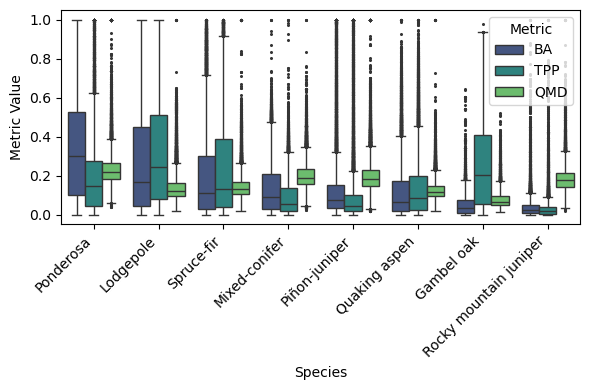

572

In [21]:
# Plot the distribution of dominance and abundance across forest species groups
# Sort species by mean dominance
sp_order = (
    grid_tm_spp_pr.groupby('species_gp_n')['ba_ld_pr']
    .mean().sort_values(ascending=False).index
)
# Reshape the data to long format for easier plotting
df_l = pd.melt(
    grid_tm_spp_pr,
    id_vars=['species_gp_n'],
    value_vars=['ba_ld_pr', 'tpp_ld_pr', 'qmd_ld_pr'],
    var_name='metric',
    value_name='value'
)

# Set up the plot
plt.figure(figsize=(6, 4))
sns.boxplot(
    data=df_l,
    x='species_gp_n',
    y='value',
    hue='metric',
    order=sp_order,
    palette='viridis',
    flierprops=dict(marker='o', markersize=1.2)
)

# Customize the plot
plt.xlabel('Species')
plt.ylabel('Metric Value')
plt.xticks(rotation=45, ha='right')

# Customize legend labels
handles, labels = plt.gca().get_legend_handles_labels()
new_labels = ['BA', 'TPP', 'QMD']  # New labels
plt.legend(
    handles=handles, 
    labels=new_labels,  # Replace default labels
    title='Metric', 
    loc='upper right', 
    bbox_to_anchor=(1, 1)
)

# Finalize and show the plot
plt.tight_layout()

# Save the plot
out_png = os.path.join(projdir, 'figures/FigureSX_TopSpecies_TreeMetrics_Proportions.png')
plt.savefig(out_png, dpi=300, bbox_inches='tight')

plt.show()

del df_l
gc.collect()

In [22]:
# save the file.
out_fp = os.path.join(projdir,'data/tabular/mod/gridstats_treetable.csv')
grid_tm_spp_pr.to_csv(out_fp)
print(f"Saved file to: {out_fp}")

Saved file to: /Users/max/Library/CloudStorage/OneDrive-Personal/mcook/aspen-fire/Aim2/data/tabular/mod/gridstats_treetable.csv


In [51]:
# merge back to the frp data
grid.drop(columns=['forest_pixels','forest_pct'], inplace=True)
grid_tm_frp = grid.merge(grid_tm_spp_pr, on='grid_index', how='inner')
grid_tm_frp.columns

Index(['grid_index', 'grid_area', 'afd_count', 'unique_days', 'overlap',
       'frp_csum', 'frp_max', 'frp_min', 'frp_mean', 'frp_p90', 'frp_p95',
       'frp_p97', 'frp_p99', 'frp_first', 'day_max_frp', 'dt_max_frp',
       'first_obs_date', 'last_obs_date', 't4_max', 't4_mean', 't5_max',
       't5_mean', 'day_count', 'night_count', 'frp_max_day', 'frp_max_night',
       'frp_csum_day', 'frp_csum_night', 'frp_mean_day', 'frp_mean_night',
       'frp_p90_day', 'frp_p90_night', 'frp_p95_day', 'frp_p95_night',
       'frp_p97_day', 'frp_p97_night', 'frp_p99_day', 'frp_p99_night',
       'frp_first_day', 'frp_first_night', 'Fire_ID', 'Fire_Name', 'geometry',
       'x', 'y', 'species_gp_n', 'tmid_n', 'forest_pct', 'ba_live', 'ba_dead',
       'ba_ld', 'tpp_live', 'tpp_dead', 'tpp_ld', 'qmd_live', 'qmd_dead',
       'qmd_ld', 'tree_ht_live', 'tree_ht_dead', 'balive_total',
       'badead_total', 'ba_ld_total', 'tpp_live_total', 'tpp_dead_total',
       'tpp_ld_total', 'qmd_live_total', '

In [52]:
del grid_tm_spp, grid_tm_spp_pr
gc.collect()

0

In [53]:
grid_tm_frp['species_gp_n'].unique()

array(['Douglas-fir', 'Engelmann spruce', 'Lodgepole pine',
       'Piñon-juniper', 'Ponderosa pine', 'Quaking aspen', 'White fir',
       'Gambel oak', 'Rocky mountain juniper', 'Subalpine fir'],
      dtype=object)

In [54]:
# Save this table out.
# First, extract centroid coords
df = grid_tm_frp.copy()
df = df.to_crs(4326) # WGS coords for lat/lon
df['x'] = df.geometry.centroid.x  # Longitude (x-coordinate)
df['y'] = df.geometry.centroid.y 
# remove the geomtry field before exporting
df.drop(columns=['geometry'], inplace=True)

# save the file.
out_fp = os.path.join(projdir,'data/tabular/mod/gridstats_treetable_frp.csv')
df.to_csv(out_fp)
print(f"Saved file to: {out_fp}")

del df
gc.collect()

Saved file to: /Users/max/Library/CloudStorage/OneDrive-Personal/mcook/aspen-fire/Aim2/data/tabular/mod/gridstats_treetable_frp.csv


0

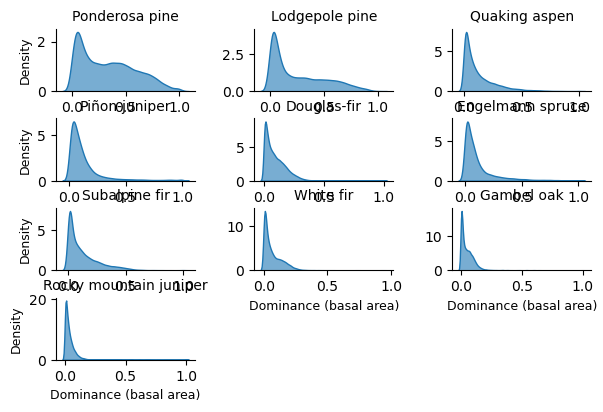

In [55]:
# plot the distribution of percent cover by forest types
grid_tm_frp['species_gp_n'] = grid_tm_frp['species_gp_n'].astype('category')

spp_order = top_species[top_species['species_gp_n'].isin(grid_tm_frp['species_gp_n'].unique())]
spp_order = spp_order['species_gp_n'].tolist()
grid_tm_frp['species_gp_n'] = pd.Categorical(
    grid_tm_frp['species_gp_n'],
    categories=spp_order,
    ordered=True
)

# Create a FacetGrid with the specified order
g = sns.FacetGrid(
    data=grid_tm_frp,
    col='species_gp_n',      
    col_wrap=3,             
    sharex=False,            
    sharey=False,            
    height=2,               
    aspect=1.2              
)

# Map a KDE plot to each facet
g.map(sns.kdeplot, 'ba_ld_pr', fill=True, alpha=0.6)

# Customize the plot
g.set_titles("{col_name}")  # Use species names as titles
g.set_axis_labels("Dominance (basal area)", "Density", size=9)  # Axis labels
g.fig.set_size_inches(6,4)  # Set figure dimensions
plt.subplots_adjust(top=0.9)  # Adjust subplot spacing

# Show the plot
plt.show()

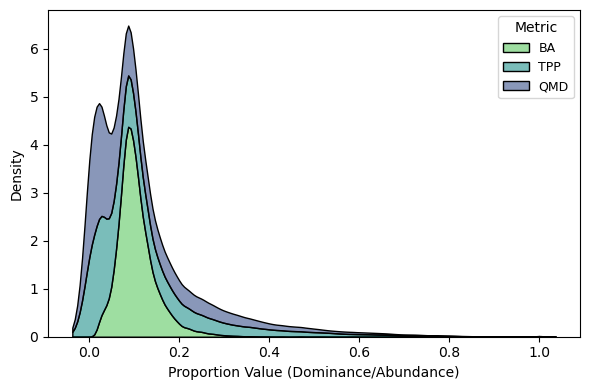

In [56]:
df_long = pd.melt(
    grid_tm_frp,
    id_vars=['species_gp_n'],
    value_vars=['ba_ld_pr', 'tpp_ld_pr', 'qmd_ld_pr'],
    var_name='metric',
    value_name='value'
)

# Set the order of species
spp_order = top_species[top_species['species_gp_n'].isin(spps)]
spp_order = spp_order['species_gp_n'].tolist()
df_long['species_gp_n'] = pd.Categorical(
    df_long['species_gp_n'],
    categories=spp_order,
    ordered=True
)

# Just plot one species
df_long = df_long[df_long['species_gp_n'] == 'Quaking aspen']

# Create the plot with stacked densities
plt.figure(figsize=(6,4))

# Use seaborn's KDE plot for each metric, with species as rows (stacked)
sns.kdeplot(
    data=df_long,
    x='value',
    hue='metric',  # Separate densities by metric
    multiple='stack',  # Stack densities
    fill=True,         # Fill densities for stacking effect
    palette='viridis',
    alpha=0.6
)

# Customize the plot
plt.xlabel("Proportion Value (Dominance/Abundance)", fontsize=10)
plt.ylabel("Density", fontsize=10)
plt.legend(title="Metric", labels=["BA", "TPP", "QMD"], fontsize=9)
plt.tight_layout()

# Show the plot
plt.show()

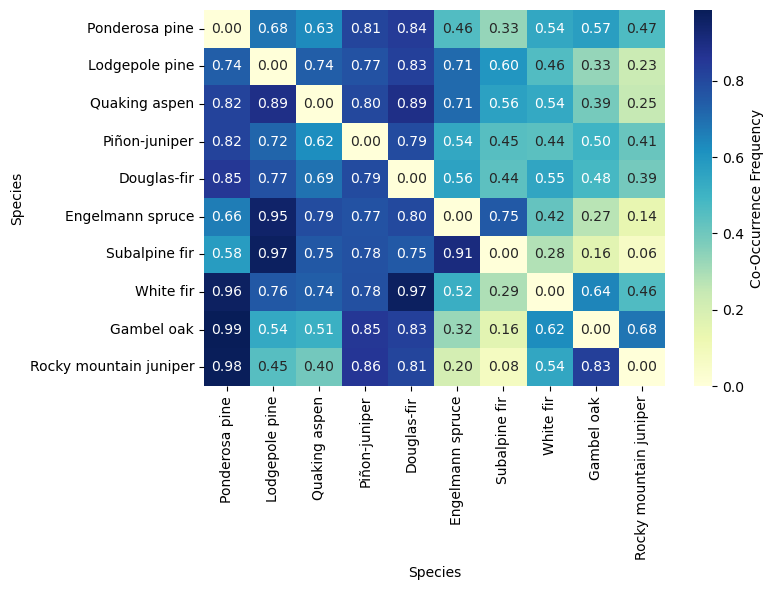

In [57]:
# Species co-occurrence plot
# Threshold species presence where dominance/abundance > 1% of total
dt = 0.01
# Create a binary presence-absence matrix
pres_abs = (
    grid_tm_frp
    .pivot_table(index='grid_index', columns='species_gp_n', values='ba_ld_pr', aggfunc='first')
    .fillna(0)
    .applymap(lambda x: 1 if x >= dt else 0)  # Convert to binary
)

# get the species names and matrix
species = pres_abs.columns
coo_mat = pd.DataFrame(0, index=species, columns=species)
# map across species combinations
for sp1, sp2 in combinations(species, 2):
    # Count co-occurrence (grids where both species are present)
    coo = np.sum(pres_abs[sp1] & pres_abs[sp2])
    coo_mat.loc[sp1, sp2] = coo
    coo_mat.loc[sp2, sp1] = coo  # Symmetry

# Optional: Normalize by the total number of grids for each species
species_totals = pres_abs.sum(axis=0)
norm_mat = coo_mat.div(species_totals, axis=0)

# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(
    norm_mat, 
    annot=True, 
    fmt=".2f", 
    cmap="YlGnBu", 
    cbar_kws={'label': 'Co-Occurrence Frequency'}
)
plt.xlabel("Species")
plt.ylabel("Species")
plt.tight_layout()

out_png = os.path.join(projdir, 'figures/FigureX_Species_CoOccurrence.png')
plt.savefig(out_png, dpi=300, bbox_inches='tight')

plt.show()